<a href="https://colab.research.google.com/github/uumami/workshop_riskmathics/blob/main/04_entrenamiento_de_redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias

In [ ]:
#Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# MNIST

## Lectura de datos




In [ ]:
# Diccionarios de argumentos
args={}
kwargs={}

# Tamano de lote o Batch
args['batch_size']=1000
args['test_batch_size']=1000

# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.01 
# El momento o momentum del descenso por gradiente
args['momentum']=0.5 

# Parametros de Pytorch
# Semilla aleatoria
args['seed']=345 
args['log_interval']=10
# Usar GPU si existe (cuda), de lo contrario cpu.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
args['cuda']= device


Using device: cuda



El siguiente bloque carga los datos, y los divide en entrenamiento y prueba. 


```
torch.utils.data.DataLoader
```
https://pytorch.org/docs/stable/data.html  
Es el metodo que nos permite cargar los datos y preparlos para el entrenamiento y validacion.  
En este caso recibe 3 argumentos.
+ **datasets.MNIST**:= Indica que datos queremos, en este caso MNIST.
+ **batch_size**:= el tamano del lote o del batch de entrenamiento.
+ **shuffle**:= Si queremos barajear nuestro dataset cada epoca.



```
datasets.MNIST
```
https://pytorch.org/docs/stable/torchvision/datasets.html#mnist 
Es el metodo que llama a los datos del MNIST en particular.  
En este caso recibe 4 argumentos
+ **root**:= Directorio donde existe o descargaran las imagenes o datos.
+ **train**:= Si utiliza los datos de entrenamiento o no.
+ **download**:= Si descarga los datos o no. Si los datos ya estan en le directorio especificado por root no descarga.
+ **transform**:= Si aplica transformaciones a las imagenes.



```
transforms.Compose
```
https://pytorch.org/docs/stable/torchvision/transforms.html  
Esta funcion nos permite anidar transformaciones, parecido al metodo sequential que usamos apra construir redes, pero aplicado a transformaciones.  
En este caso pasamos 2 transformaciones:
+ **transform.ToTensor**:= Convierte las imagenes a un tensor, que es el tipo de estructura de datos que utiliza pytorch.
+ **transform.Normalize**:= Normaliza los tensores. Debemos aplicar la misma normalizacion a los datos de entrenamiento que a los de prueba.
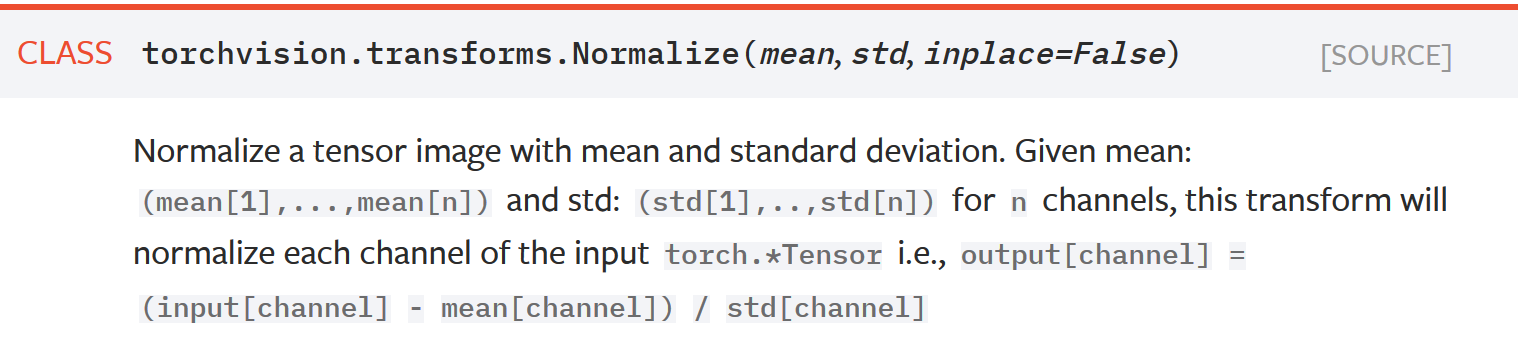






In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], 
    shuffle=True)


+ Media y desviacion estandard de un solo lote o batch. 
+ Graficar una observacion

Dimension del batch (numero de obs en el batch, canales, altura, ancho)
 torch.Size([1000, 1, 28, 28])

Media del batch:   tensor(0.1323)
Std del batch:   tensor(0.3099)
Contenido de una observacion en formato tensorial 
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.00

([], <a list of 0 Text major ticklabel objects>)

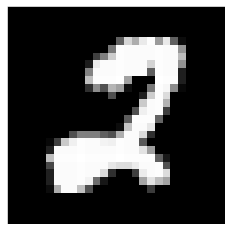

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print('Dimension del batch (numero de obs en el batch, canales, altura, ancho)\n'
 ,example_data.shape)
print('\nMedia del batch:  ', torch.mean(example_data))
print('Std del batch:  ', torch.std(example_data))
print('Contenido de una observacion en formato tensorial \n', example_data[0][0])

fig = plt.figure()
plt.tight_layout()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])

Veamos la media y desviacion estandard de todos los batches de entrenamiento.

In [ ]:
examples = enumerate(train_loader)

# Listas para guardar resultados por batch
batch_mean = []
batch_std = []
batch_labels = []

for batch_idx, (example_data, example_targets) in examples:
  batch_mean.append(torch.mean(example_data).item())
  batch_std.append(torch.std(example_data).item())
  batch_labels.append(example_targets)

# Convertir las etiquetas a numpy array
batch_labels = map(lambda x: x.numpy(), batch_labels )
batch_labels = np.concatenate(list(batch_labels))
batch_labels

array([7, 2, 2, ..., 4, 0, 9])

**Distribucion/balanceo de las etiquetas**

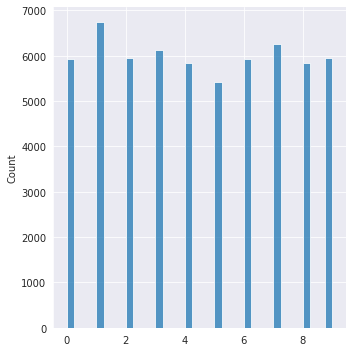

In [ ]:
sns.displot(data=batch_labels)

**Histograma de la Media de pixeles**

Media de pixeles:   0.13066047901908556


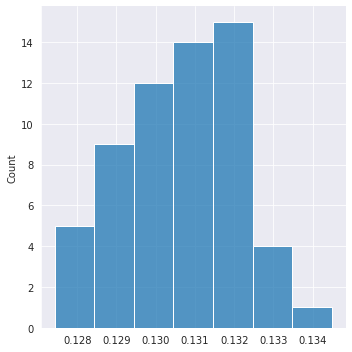

In [ ]:
sns.displot(data=batch_mean)
print('Media de pixeles:  ',sum(batch_mean)/len(batch_mean))

**Histograma de la std de los pixeles**

Std de pixeles:   0.3080998033285141


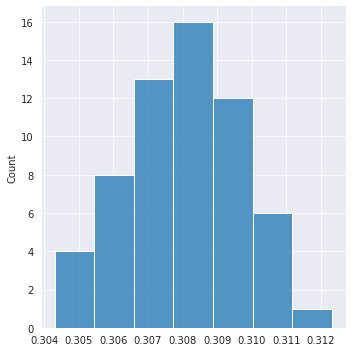

In [ ]:
print('Std de pixeles:  ',sum(batch_std)/len(batch_std))
sns.displot(data=batch_std)

Vistazo a los datos de prueba, con y sin normalizacion. En este caso a simple vista no hay mucha diferencia, aun asi es importante normalizar!  
En esta ocasion como las imagenes son en blanco y negro, solo tenemos un canal.

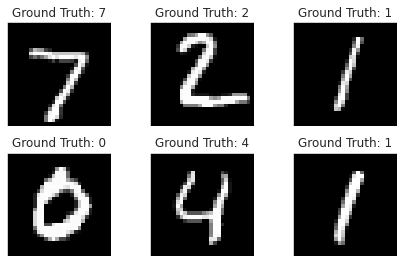

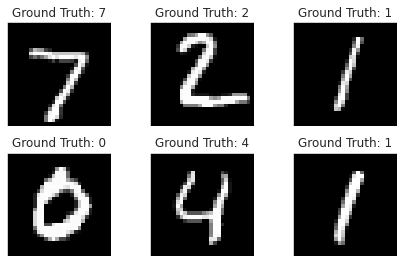

In [ ]:

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

torch.Size([1000, 1, 28, 28])


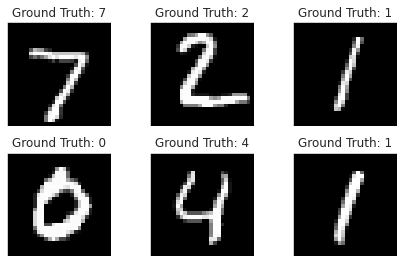

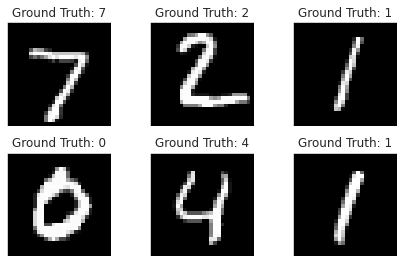

In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Carguemos los datos que utilizaremos, observa que argumentos cambian, respecto a los bloques anteriores.


In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=False, 
                   download = True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=True)

### Resumen de lectura de datos

+ Hemos cargado los datos, y los hemos dividido entre entrenamiento y prueba.
+ Hemo visto la distribucion de las etiquetas (labels) en el entrenamiento, que parece bastante balanceada.
+ Hemos obtenido la media y std de los datos de entrenamiento.
+ Normalizamos los datos.
+ Revisamos la integridad de los datos.  
Hemos realizado con exito el ETL, y parte del EDA

## Definamos la Red Neuronal

Utilizemos el metodo de red neuronal que definimos la clase pasada.

In [ ]:
from torch import nn

class RedNeuronal(nn.Module):

    def __init__(self, in_n=784, hidden_n=256, out_n=1):
        super(RedNeuronal, self).__init__()
        
        # W0:= Pesos entrada -> oculta 
        # nn.Linear(neuronas de entrada, neuronas ocultas, bias=True)
        self.hidden = nn.Linear(in_n, hidden_n)

        # W1:= Pesos oculta -> salida 
        # nn.Linear(neuronas ocultas, neuronas salida, bias=True)
        self.output = nn.Linear(hidden_n, out_n)
        
        # Funciones de Activacion 
        # Sigma 1 [capa oculta]
        self.sigmoid = nn.Sigmoid()
        # Sigma 2 [capa de salida]
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Flujo o feedforward de nuestra red

        # Flatten tensores de imagenes
        x = x.view(x.size(0), -1)
        # Multiplicacion de X0 por W0
        x = self.hidden(x)
        # Evaluar Sigma uno / Obtener X1
        x = self.sigmoid(x)
        # Multiplicacion de X1 por W1
        x = self.output(x)
        # Evaluar en Sigma 2 / Obtener X2
        x = F.log_softmax(x, dim=1)
        return x

## Definamos la funcion para evaluar nuestro modelo

+ **model.eval**:= Pone al modelo en modo de evaluacion. No calcula el gradiente, y desactiva el comportamiento de entrenamiento. Por ejemplo, descativa el dropout de neuronas.
+ **.cuda()** = carga el tensor al GPU
+ **F.nll_loss**:= Funcion negative log-likelihood 
+ **output.data.max**:= Nos regresa el valor maximo del tensor, y el indice que le corresponde.

In [ ]:
def prueba(model, test_loader, args):
    # Cambia el modelo a modo evaluacion, por ejemplo elimina el dropout
    model.eval()
    # Variables oara accumular en el loop
    test_loss = 0
    correct = 0

    # Iterar sobre los batches/lotes de prueba
    for data, target in test_loader:

        # Carga los tensores a GPU de ser necesario
        if args['cuda'] == 'cuda':
            data, target = data.cuda(), target.cuda()

        # Resultado del feedforward
        output = model(data)

        # Funcion de perdida en el batch, negative log-likelihood loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()

        # Obtener la neurona -> label con mayor probabilidad
        # La neurona k corresponde al numero k o etiqueta k.
        pred = output.data.max(1, keepdim=True)[1] 

        # Numero de predicciones correctas, .cpu() copia los tensores al cpu
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    # % de obsrvaciones correctas
    test_loss /= len(test_loader.dataset)
    print('\n Datos de Prueba: Perdida: {:.3f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
prueba(model = model_nn, test_loader=test_loader, args=args)


 Datos de Prueba: Perdida: 2.366, Accuracy: 885/10000 (9%)



Podemos observar que nuestra red no esta entrenada de manera optima, pues el accuracy es cercano al 10%. Esto es equivalente a elegir al azar. 
  
Debemos entrenar nuestra red.

## Definamos la funcion de entrenamiento

Definamos la funcion de entrenamiento, para una epoca. Nuestro modelo evalua cada lote/batch una vez.
+ **model.train()**:= Pone al modelo en modo de entrenamiento. Activa el dropout y calcula el gradiente.
+ **Variable()**:= Es un wrapper alrededor de la clase tensor de Pytorch, que permite guardar operaciones intermedias, y calcular el gradiente.  
+ **.backward()**:= Computa el gradiente de los pesos, con la informacion de un objeto tipo Variable.
+ **step.()**:= Calcula/actualiza los pesos de acuerdo al gradiente.

In [ ]:
def entrenamiento(model, train_loader, args, epoch):
    # Pone al modelo en modo entrenamiento. Calcula autograd, y activa el dropout.
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # carga las matrices al GPU de ser necesario
        if args['cuda'] == 'cuda':
            data, target = data.cuda(), target.cuda()

        # Convierte el tensor a Variable para calcular la derivada 
        data, target = data, target

        # Reinicia el gradiente del lote a 0
        optimizer.zero_grad()

        # Feedforward
        output = model(data)

        # Calcula la perdida log-loss
        loss = nn.NLLLoss()
        loss = loss(output, target)

        # Calcula el gradiente (backward) 
        loss.backward()

        # Optimiza/recalcula los pesos
        optimizer.step()

        # Imprime la perdida. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [ ]:
args['lr']=0.1
model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

for epoch in range(1, 2):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332447
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.853288
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.332972
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.995672
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.844228
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.745807

 Datos de Prueba: Perdida: 0.611, Accuracy: 8622/10000 (86%)



Podemos observar que la perdida se redujo un poco. Entrenemos por 10 epocas.

## Entrenar por mas epocas

In [ ]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']= 5 
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.1

model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.327462
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.847090
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.361423
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.979688
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.815607
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.718800

 Datos de Prueba: Perdida: 0.610, Accuracy: 8668/10000 (87%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.622545
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.599308
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.541499
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.479790
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.461172
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.469378

 Datos de Prueba: Perdida: 0.419, Accuracy: 8922/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.427867
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.404605
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.440818
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.408066
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.382524
Train Epoch: 2 [50000/60000 (83%)]	Loss

Podemos observar que nuestro modelo mejoro bastante cuando lo entrenamos por mas epocas.

### Entrenemos con un learning_rate diferente.

In [ ]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.1


model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.344732
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.832098
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.483282
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.371249
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.404701
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.373746

 Datos de Prueba: Perdida: 0.316, Accuracy: 9123/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.363220
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.334281
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.314859
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.301585
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.263895
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.286123

 Datos de Prueba: Perdida: 0.255, Accuracy: 9285/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.269293
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.213984
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.223192
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.247913
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.236487
Train Epoch: 2 [50000/60000 (83%)]	Loss

Intentemos entrenar la red que ya tenemos, con un learning rate muy grande.
Esperariamos que nuestras predicciones se comportaran como pendulo, pues un learning rate grande tiende al sobre ajuste.

**Learning Rate grande**

In [ ]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch'] = 5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr'] = 1000


optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 146946.484375
Train Epoch: 0 [10000/60000 (17%)]	Loss: 151882.453125
Train Epoch: 0 [20000/60000 (33%)]	Loss: 144424.718750
Train Epoch: 0 [30000/60000 (50%)]	Loss: 147809.734375
Train Epoch: 0 [40000/60000 (67%)]	Loss: 146648.796875
Train Epoch: 0 [50000/60000 (83%)]	Loss: 143233.687500

 Datos de Prueba: Perdida: 146688.811, Accuracy: 2358/10000 (24%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 151395.437500
Train Epoch: 1 [10000/60000 (17%)]	Loss: 150715.796875
Train Epoch: 1 [20000/60000 (33%)]	Loss: 146967.437500
Train Epoch: 1 [30000/60000 (50%)]	Loss: 146183.875000
Train Epoch: 1 [40000/60000 (67%)]	Loss: 145185.421875
Train Epoch: 1 [50000/60000 (83%)]	Loss: 148292.062500

 Datos de Prueba: Perdida: 146688.243, Accuracy: 2358/10000 (24%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 151270.281250
Train Epoch: 2 [10000/60000 (17%)]	Loss: 142269.031250
Train Epoch: 2 [20000/60000 (33%)]	Loss: 154656.218750
Train Epoch: 2 [30000/60000 (50%)]	Loss: 146278.031250

**Learning rate Pequeno**

In [ ]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.0001


model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.414240
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.405105
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.390940
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.398146
Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.380965
Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.386402

 Datos de Prueba: Perdida: 2.382, Accuracy: 958/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.367470
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.359528
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.391981
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.356891
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.364297
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.374742

 Datos de Prueba: Perdida: 2.366, Accuracy: 958/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.366585
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.352600
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.364908
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.368424
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.364758
Train Epoch: 2 [50000/60000 (83%)]	Loss: 

**En general** Queremos que nuestro learning rate, se encuentre entre 0.0 y 1.0.  
+ Existe una compensacion inversa entre el learning rate, y el numero de epocas. Si tuvieramos tiempo y recuros, lo ideal seria tener un learning rate bajo y entrenar por muchas epocas.
+ Tambien es conventiente intentar varios learning rates, con pocas epocas para detectar optimos locales, o en su defecto empezar con diferentes pesos iniciales, como en nuestro caso.

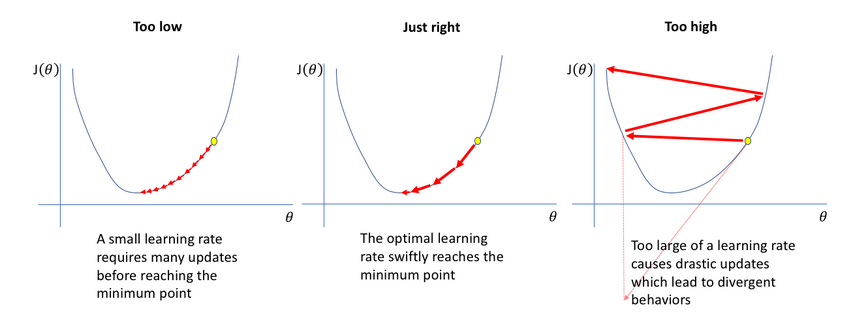

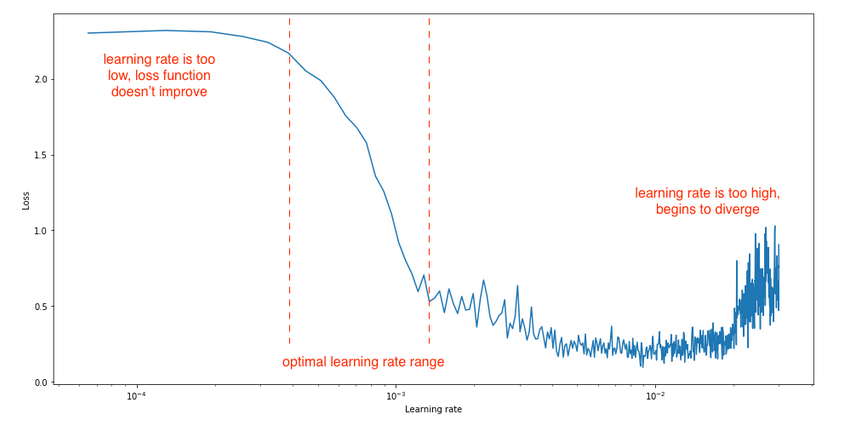

Fuente: https://www.kaggle.com/residentmario/tuning-your-learning-rate

### Entrenemos con Pocas Neuronas

In [ ]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=1.0


model_nn = RedNeuronal(in_n=784, hidden_n=2, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.469716
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.963518
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.767813
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.664139
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.597234
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.529580

 Datos de Prueba: Perdida: 1.475, Accuracy: 3842/10000 (38%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.491285
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.426256
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.423156
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.447940
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.469848
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.355132

 Datos de Prueba: Perdida: 1.380, Accuracy: 4012/10000 (40%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.390270
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.426491
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.407552
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.356560
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.330762
Train Epoch: 2 [50000/60000 (83%)]	Loss

### Entrenemos con muchas Neuronas

In [ ]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=1.0


model_nn = RedNeuronal(in_n=784, hidden_n=5000, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.364232
Train Epoch: 0 [10000/60000 (17%)]	Loss: 3.062061
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.462353
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.155447
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.603057
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.102906

 Datos de Prueba: Perdida: 0.776, Accuracy: 8165/10000 (82%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.755034
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.672699
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.577627
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.408475
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.424418
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.382039

 Datos de Prueba: Perdida: 0.336, Accuracy: 9117/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.337169
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.320249
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.229837
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.353018
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.324131
Train Epoch: 2 [50000/60000 (83%)]	Loss